In [ ]:
import numpy as np
import networkx as nx
import random
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import itertools
import pickle
import operator
import copy
import os
%matplotlib notebook

### Identify vulnerable individuals
We define vulnerability using two metrics, (1) fraction of times a cascade reached nodes, (2) time (steps) for a cascade to reach a node.

__Procedure__
1. initialize random network with N nodes
2. select n seeds at random
3. run spreading process, truncate spread after $t$ steps or after process has run its course (if $p_{\text{infection}} < 1$)
4. identify nodes which arent reached
5. repeat process m times
6. construct distribution of vulnerability (fraction of time node was not reached)

__Spreading dynamics__ - Independent Cascade Model
1. At $t=0$ all nodes are inactive, except seed nodes
2. Each activated node i contacts all its neighbors j and, with an independent probability p, tries to activate each of those nodes that have been never activated during previous stages of the dynamics
3. All nodes that tried to activate their neighbors at step (i) become inactive, and they cannot be activated again in subsequent stages of the dynamics. The process is iterated until no more active nodes are present

__How to select $p$?__
For a network the critical value $p_c$ separates the region of the phase-diagram where outbreaks are subextensive ($p < p_c$) from the supercritical phase ($p > p_c$) where outbreaks reach a finite fraction of the whole network.

The value of $p_c$ is determined as the position of the maximum of the susceptibility $⟨s^2⟩/⟨s⟩^2$ (where $⟨s^n⟩$ is the n-th moment of the outbreak size distribution computed for random initial single spreaders).

Read more in: _On the numerical study of percolation and epidemic critical
properties in networks_, Castellano and Pastor-Satorras (2016) [https://arxiv.org/pdf/1610.01375.pdf]

In [ ]:
def ICM_special(network,seeds,p_infection):
    '''
    Independent cascade model
    ------------------    
    Input:
    * network: directed opr undirected network (this is a slightly adapted version of the cascade model, i.e. faster, than the one used in core_functions.py)
    * seeds: list of seed nodes or number of initial seeds to simulate the dynamics from
    * p: infection/spreading probability 
    ------------------
    Output: 
    * set of nodes which have been infected
    ------------------
    '''
    if type(seeds) != list:
        infected = set(random.sample(network.nodes(),seeds)) # infect seeds
    else:
        infected = set(seeds)

    activated = infected.copy()

    # run infection process
    while infected != set():
        new_infected = set()
        for node in infected:
            for neighbor in network.neighbors(node):
                if (random.random() < p_infection) and (neighbor not in activated):
                    new_infected.add(neighbor)
                    
                    # update sets
                    activated.add(neighbor)
            # update set
            activated.add(node)
        # set of newly infected nodes
        infected = new_infected.copy()
    
    # return list of infected/recovered nodes
    return activated

# Identify $p_c$ values
__load network__

In [ ]:
from core_functions import load_network

# differet types of empirical networks we used
# network_id = 'facebook_combined'
# network_id = 'ca-AstroPh'
# network_id = 'ca-CondMat'
# network_id = 'polblogs'
# network_id = 'URVemail'
# network_id = 'ia-infect-dublin'
# network_id = 'UC_irvine'
network_id = 'village_HH_smallest'
# network_id = 'village_HH_median'
# network_id = 'village_HH_largest'

network_path = 'some_path_somewhere/'
network_path = '/Volumes/ExtremeSSD/last-mile/last_mile/networks_empirical/'
G = load_network(network_path + network_id +'.txt')

Nn = len(G.nodes()) # number of nodes n the network
print(Nn, G.number_of_edges())

__Find a $p_c$ for each network__

In [ ]:
save_path = 'some_path_somewhere'

Sp = []
#for p in np.linspace(0.003,0.012,21): # Facebook
#for p in np.linspace(0.010,0.016,13): # ca-AstroPh
#for p in np.linspace(0.06,0.068,9): # ca-AstroPh (ca-CondMat)
#for p in np.linspace(0.01,0.02,21): # polblogs 
#for p in np.linspace(0.04,0.08,41): # URVemail
#for p in np.linspace(0.052,0.068,17): # ia-infect-dublin
#for p in np.linspace(0.018,0.027,10): # UC_ivrine
for p in np.linspace(0.05,0.12,15): # village_HH_smallest
#for p in np.linspace(0.03,0.07,21): # village_HH_median
#for p in np.linspace(0.06,0.11,26): # village_HH_largest
    print '\t %.5f' % p
    S = []
    for i in range(int(Nn)/10):
        # spreading dynamics
        recovered = ICM_special(G,1,p)
        S.append(len(recovered)/float(Nn))
    Sp.append((p,np.mean(np.array(S)**2)/np.mean(S)**2))

pkl_file = open(save_path + '/%s.pkl' % network_id,'w')
pickle.dump(sorted(Sp),pkl_file)
pkl_file.close()

# plot $p_c$ curves

In [ ]:
# loads data from pickle files (created above)
load_path = 'some_path_somewhere'
files = [f for f in os.listdir(load_path) if '.pkl' in f]

Pc = dict()
for f in files:
    pkl_file = open(load_path + f,'rb')
    dat = pickle.load(pkl_file,encoding='latin1')
    pkl_file.close()
    
    Pc[f[:-4]] = dat

<IPython.core.display.Javascript object>


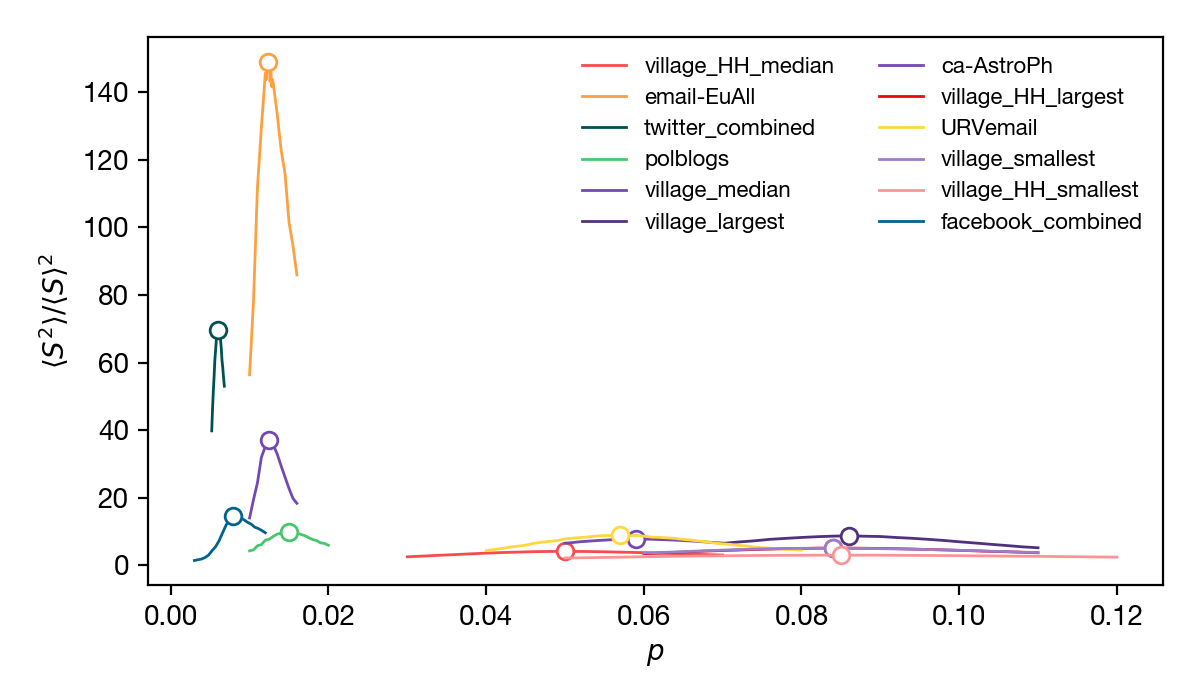

village_HH_median 0.05
email-EuAll 0.0124
twitter_combined 0.006
polblogs 0.015
village_median 0.059
village_largest 0.086
ca-AstroPh 0.0125
village_HH_largest 0.084
URVemail 0.057
village_smallest 0.084
village_HH_smallest 0.085
facebook_combined 0.00795


In [7]:
plt.figure(figsize=(6,3.5))
colors = dict([('facebook_combined','#00638E'),('ca-AstroPh','#7348B3'),('polblogs','#46C66D'),('URVemail','#ffd740'),
              ('email-EuAll','#ff9f40'),('twitter_combined','#005151'),
              ('village_HH_largest','#f00808'),('village_HH_median','#f94b4b'),('village_HH_smallest','#fb9595'),
              ('village_largest','#50327c'),('village_median','#7348b3'),('village_smallest','#9c7dcb')])

for k,Sp in Pc.iteritems():
    x,y = zip(*Sp)
    plt.plot(x,y,color=colors[k],alpha=1,lw=1,label=k)
    # plot max
    index = y.index(max(y))
    plt.plot(x[index],y[index],'-o',markerfacecolor='white',markeredgecolor=colors[k])
    print k,x[index]
 
plt.legend(loc=0,frameon=False,ncol=2,fontsize=8)
plt.ylabel(r'$\langle S^2 \rangle / \langle S \rangle ^ 2$')
plt.xlabel(r'$p$')
plt.tight_layout()
plt.show()